In [61]:
import sim
import numpy as np
import sympy as sp

def connect(port):
# Establece la conexión a VREP
# port debe coincidir con el puerto de conexión en VREP
# retorna el número de cliente o -1 si no puede establecer conexión
    sim.simxFinish(-1) # just in case, close all opened connections
    clientID=sim.simxStart('127.0.0.1',port,True,True,2000,5) # Conectarse
    if clientID == 0: print("conectado a", port)
    else: print("no se pudo conectar")
    return clientID

# Conectarse al servidor de VREP
# *** ejecutar cada vez que se reinicia la simulación ***
clientID = connect(19999)

conectado a 19999


In [62]:
returnCode,handle=sim.simxGetObjectHandle(clientID,'Dummy',sim.simx_opmode_blocking)
dummy = handle

# Identificar las Articulaciones
ret,joint1=sim.simxGetObjectHandle(clientID,'Art_1',sim.simx_opmode_blocking)
ret,joint2=sim.simxGetObjectHandle(clientID,'Art_2',sim.simx_opmode_blocking)
print(joint1,joint2)

22 23


In [77]:
q = [0,0]

returnCode = sim.simxSetJointTargetPosition(clientID, joint1, q[0], sim.simx_opmode_oneshot)
returnCode = sim.simxSetJointTargetPosition(clientID, joint2, q[1], sim.simx_opmode_oneshot)

In [10]:
#Para Mover las articulaciones
# Recordae que la pierna del robot está en > en relación a donde mira
#  _ 
#   \____ 
#    >>  >>
# Si es negativo, se mueve para adelante
# Si es positivo, se mueve para atras
# Inicio, de pie el perro
# Articulacion 1 (arriba): -90 a 30
q1 = 0 * np.pi/180
# Articulacion 2 (medio): -45 a 90
q2 = 15 * np.pi/180
returnCode = sim.simxSetJointTargetPosition(clientID, joint1, q1, sim.simx_opmode_oneshot)
returnCode = sim.simxSetJointTargetPosition(clientID, joint2, q2, sim.simx_opmode_oneshot)


In [65]:
angulo_articulacion1 = 0
angulo_articulacion2 = 0
for i in range(20):
    angulo_articulacion1 = angulo_articulacion1 + 2
    angulo_articulacion2 = angulo_articulacion2 + 2
    q1 = angulo_articulacion1 * np.pi/180
    # Articulacion 2 (medio): -45 a 90
    q2 = angulo_articulacion2 * np.pi/180
    returnCode = sim.simxSetJointTargetPosition(clientID, joint1, q1, sim.simx_opmode_oneshot)
    returnCode = sim.simxSetJointTargetPosition(clientID, joint2, q2, sim.simx_opmode_oneshot)


In [97]:
q1 = -75 * np.pi/180 # muslo
# Articulacion 2 (medio): -45 a 90
q2 = 76.604457 * np.pi/180 # rodilla
returnCode = sim.simxSetJointTargetPosition(clientID, joint1, q1, sim.simx_opmode_oneshot)
returnCode = sim.simxSetJointTargetPosition(clientID, joint2, q2, sim.simx_opmode_oneshot)

In [55]:
# Ver angulo 
returnCode, pos1 = sim.simxGetJointPosition(clientID, joint1, sim.simx_opmode_blocking)
print(pos1)

0.5235987901687622


In [5]:
# Posición
returnCode,pos=sim.simxGetObjectPosition(clientID, dummy, -1, sim.simx_opmode_blocking)
# x = adelante o atras 
# z = altura
# Print [x , y , z]
print(pos)

[-0.004999960772693157, -0.0750003233551979, 0.019999848678708076]


In [25]:
# Cinematica Directa
q1 = -40 * np.pi/180
# Articulacion 2 (medio): -45 a 90
q2 = 90 * np.pi/180

x = 0.2*np.cos(q1+q2)+0.3*np.cos(q1)
y = 0.2*np.sin(q1+q2)+0.3*np.sin(q1)
print(x,y)

0.35837085487300124 -0.03962739428216616


### MOVER A DESTINO

In [37]:
import math
returnCode,target=sim.simxGetObjectHandle(clientID,'target',sim.simx_opmode_blocking)
returnCode,p=sim.simxGetObjectPosition(clientID, target, -1, sim.simx_opmode_blocking)
a,b = p[0], p[2]
print(a,b)

# Función para calcular la cinemática inversa de una pierna de dos articulaciones
def calcular_cinematica_inversa(x, y, L1, L2):
    # Calcular el ángulo del muslo (hip)
    theta1 = math.atan2(y, x)

    # Calcular el ángulo de la rodilla (knee)
    r = math.sqrt(x**2 + y**2)
    theta2 = math.acos((L1**2 + L2**2 - r**2) / (2 * L1 * L2))

    return math.degrees(theta1), math.degrees(theta2)

# Valores de prueba
L1 = 0.06
L2 = 0.06
a,b = p[0], p[2]
# Calcular la cinemática inversa
theta1, theta2 = calcular_cinematica_inversa(a, b, L1, L2)

# Imprimir los resultados
print("Ángulo del muslo (hip):", theta1)
print("Ángulo de la rodilla (knee):", theta2)
#q1 = theta1 * np.pi/180
# Articulacion 2 (medio): -45 a 90
#q2 = theta2 * np.pi/180
returnCode = sim.simxSetJointTargetPosition(clientID, joint1, theta2, sim.simx_opmode_oneshot)
returnCode = sim.simxSetJointTargetPosition(clientID, joint2, theta1, sim.simx_opmode_oneshot)

-0.04206499829888344 0.07999999821186066
Ángulo del muslo (hip): 117.73595430391761
Ángulo de la rodilla (knee): 97.73825144411063


In [106]:
def symTfromDH(theta,d,a,alpha):
    # theta y alpha en radianes
    # d y a en metros
    Rz = sp.Matrix([[sp.cos(theta), -sp.sin(theta), 0, 0],
                    [sp.sin(theta), sp.cos(theta), 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1]
                    ])
    tz = sp.Matrix([[1, 0, 0, 0],
                    [0, 1, 0, 0],
                    [0, 0, 1, d],
                    [0, 0, 0, 1],
                    ])
    ta = sp.Matrix([[1, 0, 0, a],
                    [0, 1, 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1],
                    ])
    Rx = sp.Matrix([[1, 0, 0, 0],
                    [0, sp.cos(alpha), -sp.sin(alpha), 0],
                    [0, sp.sin(alpha), sp.cos(alpha), 0],
                    [0, 0, 0, 1],
                    ])
    T = Rz*tz*ta*Rx
    return T

In [15]:
# Matriz de Denavit-Hartenber
#   theta   |   d   |   a   |   alpha
# ------------------------------------
#   q1      |  0.15  | 0.06  |   90
#   q2      |  0.1   | 0.06  |   90
# ------------------------------------
#

In [107]:
q1 = sp.symbols('q1')
T01 = symTfromDH(q1, 0.15, 0.06, 0)
T01

Matrix([
[cos(q1), -sin(q1), 0, 0.06*cos(q1)],
[sin(q1),  cos(q1), 0, 0.06*sin(q1)],
[      0,        0, 1,         0.15],
[      0,        0, 0,            1]])

In [108]:
q2 = sp.symbols('q2')
T02 = symTfromDH(q2, 0.1, 0.06, 0)
T02

Matrix([
[cos(q2), -sin(q2), 0, 0.06*cos(q2)],
[sin(q2),  cos(q2), 0, 0.06*sin(q2)],
[      0,        0, 1,          0.1],
[      0,        0, 0,            1]])

In [109]:
T0e = T01 * T02
T0e

Matrix([
[-sin(q1)*sin(q2) + cos(q1)*cos(q2), -sin(q1)*cos(q2) - sin(q2)*cos(q1), 0, -0.06*sin(q1)*sin(q2) + 0.06*cos(q1)*cos(q2) + 0.06*cos(q1)],
[ sin(q1)*cos(q2) + sin(q2)*cos(q1), -sin(q1)*sin(q2) + cos(q1)*cos(q2), 0,  0.06*sin(q1)*cos(q2) + 0.06*sin(q1) + 0.06*sin(q2)*cos(q1)],
[                                 0,                                  0, 1,                                                        0.25],
[                                 0,                                  0, 0,                                                           1]])

In [110]:
T = sp.simplify(T0e)
T

Matrix([
[cos(q1 + q2), -sin(q1 + q2), 0, 0.06*cos(q1) + 0.06*cos(q1 + q2)],
[sin(q1 + q2),  cos(q1 + q2), 0, 0.06*sin(q1) + 0.06*sin(q1 + q2)],
[           0,             0, 1,                             0.25],
[           0,             0, 0,                                1]])

### Cinematica Inversa

In [130]:
returnCode,target=sim.simxGetObjectHandle(clientID,'target',sim.simx_opmode_blocking)
returnCode,p=sim.simxGetObjectPosition(clientID, target, -1, sim.simx_opmode_blocking)
x,y,z = p[0],p[1],p[2]
print(x,y,z)

-0.04206499829888344 -0.07999999821186066 0.07999999821186066


In [131]:
eq1 = T[3] - x

In [132]:
eq2 = T[7] - z

In [133]:
q = sp.nsolve((eq1,eq2),(q1,q2),(1,1))
q

Matrix([
[1.33701087020697],
[1.43573836074796]])

In [134]:
returnCode = sim.simxSetJointTargetPosition(clientID, joint1, q[0], sim.simx_opmode_oneshot)
returnCode = sim.simxSetJointTargetPosition(clientID, joint2, q[1], sim.simx_opmode_oneshot)

#### Ecuacion de cinematica directa

In [ ]:
c12 =12
c1 = 12
s12 =12
s1 = 12
x = 0.06 * c12 + 0.06 * c1
y = 0.06 * s12 + 0.06 * s1

In [6]:
returnCode,target=sim.simxGetObjectHandle(clientID,'target',sim.simx_opmode_blocking)
returnCode,p=sim.simxGetObjectPosition(clientID, target, -1, sim.simx_opmode_blocking)
a,b = p[0], p[1]
print(a,b)

-0.04206499829888344 -0.07500080019235611


In [170]:
q2 = np.arccos((a**2+b**2-0.13)/0.12)
q2

C:\Users\jorge\AppData\Local\Temp\ipykernel_7988\637676603.py:1: RuntimeWarning: invalid value encountered in arccos
  q2 = np.arccos((a**2+b**2-0.13)/0.12)


nan

In [171]:
# debe entregar un valor ente 0.0  y 3.1415 (pi)
for q1 in np.arange(0,np.pi,0.0001):
    if abs(0.2*np.cos(q1+q2)+0.3*np.cos(q1) - a) < 0.001:
        break
q1 

3.1415

### CALCULO DE LA PARABOLA DE MOVIMIENTO

In [100]:
import matplotlib.pyplot as plt

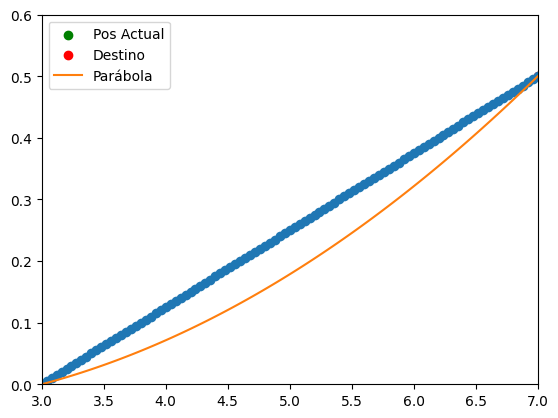

In [113]:
# Puntos dados

# x = pos x   ,   y = pos z
x1, y1 = 3, 0 # Posicion actual del dummy
x2, y2 = x1+4, y1 # Posicion deseada del dummy

# Resolver el sistema de ecuaciones para obtener los coeficientes de la parábola
A = np.array([  [x1 ** 2, x1, 1],
                [x2 ** 2, x2, 1],
                [0  ** 2,  0, 1]])
b = np.array([y1, y2, 0])
coeffs = np.linalg.solve(A, b)

# Generar puntos a lo largo de la parábola
x = np.linspace(x1, x2, 100)
y = coeffs[0] * x**2 + coeffs[1] * x + coeffs[2]

num_points = 100
retornoX = [x1 + i * (x2 - x1) / num_points for i in range(num_points+1)]
retornoY = [y1 + i * (y2 - y1) / num_points for i in range(num_points+1)]

# Dibujar la línea de puntos
plt.plot(retornoX, retornoY, marker='o', linestyle='dotted')

# Dibujar los puntos y la parábola
plt.scatter([x1], [y1], color='green', label='Pos Actual')
plt.scatter([x2], [y2], color='red', label='Destino')
plt.plot(x, y, label='Parábola')
plt.legend()

# Opcional: establecer límites de los ejes para una mejor visualización
plt.xlim(x1, x2)
plt.ylim(y1, y2*1.2)

# Mostrar el gráfico
plt.show()

[ 0.          0.03999592  0.07917559  0.11753903  0.15508622  0.19181716
  0.22773186  0.26283032  0.29711254  0.33057851  0.36322824  0.39506173
  0.42607897  0.45627997  0.48566473  0.51423324  0.54198551  0.56892154
  0.59504132  0.62034486  0.64483216  0.66850321  0.69135802  0.71339659
  0.73461892  0.755025    0.77461484  0.79338843  0.81134578  0.82848689
  0.84481175  0.86032038  0.87501275  0.88888889  0.90194878  0.91419243
  0.92561983  0.936231    0.94602592  0.95500459  0.96316702  0.97051321
  0.97704316  0.98275686  0.98765432  0.99173554  0.99500051  0.99744924
  0.99908173  0.99989797  0.99989797  0.99908173  0.99744924  0.99500051
  0.99173554  0.98765432  0.98275686  0.97704316  0.97051321  0.96316702
  0.95500459  0.94602592  0.936231    0.92561983  0.91419243  0.90194878
  0.88888889  0.87501275  0.86032038  0.84481175  0.82848689  0.81134578
  0.79338843  0.77461484  0.755025    0.73461892  0.71339659  0.69135802
  0.66850321  0.64483216  0.62034486  0.59504132  0

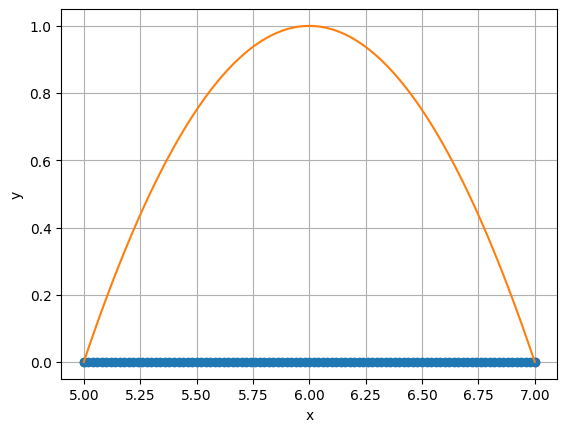

In [149]:
# Puntos
x1, y1 = 5, 0
x2, y2 = 7, 0

if y1 == 0 and y2 == 0:
    # Parámetro para modificar la curvatura
    a = -1.0  # Puedes ajustar este valor para cambiar la curvatura de la parábola
    # Generar valores de x
    x = np.linspace(x1, x2, 100)
    # Calcular valores de y utilizando la ecuación de la parábola
    y = a * (x - x1) * (x - x2)

num_points = 100
retornoX = [x1 + i * (x2 - x1) / num_points for i in range(num_points+1)]
retornoY = [y1 + i * (y2 - y1) / num_points for i in range(num_points+1)]

# Dibujar la línea de puntos
plt.plot(retornoX, retornoY, marker='o', linestyle='dotted')
# Graficar la parábola
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y')
# Dibujar los puntos y la parábola
plt.scatter([x1], [y1], color='green', label='Pos Actual')
plt.scatter([x2], [y2], color='red', label='Destino')
plt.grid(True)
plt.show()

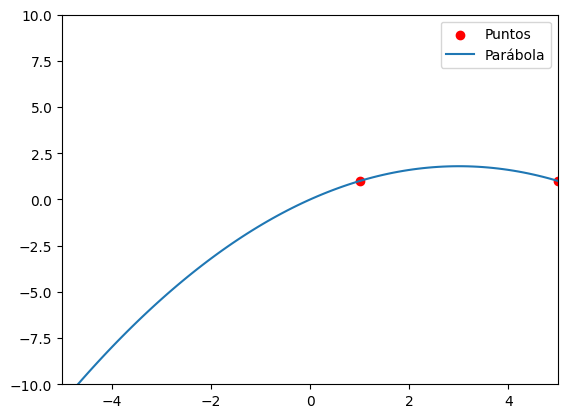

In [150]:
# Puntos dados
x1, y1 = 1, 1
x2, y2 = 5, 1

# Resolver el sistema de ecuaciones para obtener los coeficientes de la parábola
A = np.array([[x1**2, x1, 1],
              [x2**2, x2, 1],
              [0**2, 0, 1]])
b = np.array([y1, y2, 0])
coeffs = np.linalg.solve(A, b)

# Generar puntos a lo largo de la parábola
x = np.linspace(-5, 5, 100)
y = coeffs[0] * x**2 + coeffs[1] * x + coeffs[2]

# Dibujar los puntos y la parábola
plt.scatter([x1, x2], [y1, y2], color='red', label='Puntos')
plt.plot(x, y, label='Parábola')
plt.legend()

# Opcional: establecer límites de los ejes para una mejor visualización
plt.xlim(-5, 5)
plt.ylim(-10, 10)

# Mostrar el gráfico
plt.show()